In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from warnings import filterwarnings
filterwarnings('ignore')
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
def load_dataset(name):
    path = os.path.join("..", "datasets", name)
    data = pd.read_csv(path)
    data = data.values
    xs = data[:, :-1]
    ys = data[:, -1]
    return xs, ys

In [3]:
nois_x, nois_y = load_dataset("noisysine.csv")
hydr_x, hydr_y = load_dataset("hydrodynamics.csv")

In [4]:
nois_train_x, nois_val_x, nois_train_y, nois_val_y = train_test_split(
    nois_x, nois_y, test_size=0.2)
hydr_train_x, hydr_val_x, hydr_train_y, hydr_val_y = train_test_split(
    hydr_x, hydr_y, test_size=0.2)

In [5]:
def r2_score(y, y_):
    y_mean = np.full(y.shape, y.mean())
    return 1 - ((y - y_) ** 2).sum() / ((y_mean - y) ** 2).sum()

In [6]:
def draw(xs, ys, foo, deg, name, a=0, used_features=None):
    plt.cla()
    
    delta = 0.025
    xx = np.arange(np.min(xs[:, 0]) - 0.5, np.max(xs[:, 0]) + 0.5, delta)
    xx = xx.reshape(-1, 1)
    
    poly = PolynomialFeatures(degree=deg)
    xsp = poly.fit_transform(xs)
    xxp = poly.fit_transform(xx)
    
    plt.plot(xx[:, 0], foo(xxp))
    
    plt.plot(xs[:, 0], ys, 'ro', c='r')
    
    plt.title("degree = {}, R^2 score on {} = {:.4f}, alpha = {:.20f}{}".format(
              deg, name, r2_score(ys, foo(xsp)), a,
              "" if used_features is None else ", used features = {}".format(used_features)))
    plt.show()

In [7]:
class Regression:
    def __init__(self, alpha=0):
        self.a = alpha
    
    def fit(self, xs, ys):
        self.w = np.linalg.inv(np.transpose(xs) @ xs + self.a * np.identity(xs.shape[1])) @ np.transpose(xs) @ ys
        
    def predict(self, xs):
        return xs @ self.w

In [8]:
def train(train_xs, train_ys, val_xs, val_ys, regression, deg=1, a=0):
    poly = PolynomialFeatures(degree=deg)
    train_xs_p = poly.fit_transform(train_xs)
    val_xs_p = poly.fit_transform(val_xs)
    
    reg = regression(alpha=a)
    reg.fit(train_xs_p, train_ys)
    train_r2 = r2_score(train_ys, reg.predict(train_xs_p))
    val_r2 = r2_score(val_ys, reg.predict(val_xs_p))
    
    return reg, (train_r2, val_r2)

In [9]:
def train_and_draw(train_xs, train_ys, val_xs, val_ys, regression, deg=1, a=0):
    reg, _ = train(train_xs, train_ys, val_xs, val_ys, regression, deg=deg, a=a)
    
    draw(train_xs, train_ys, reg.predict, deg, name="train")
    draw(val_xs, val_ys, reg.predict, deg, name="val")

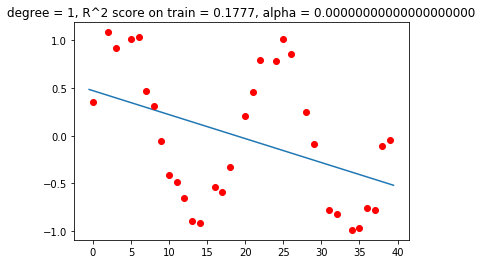

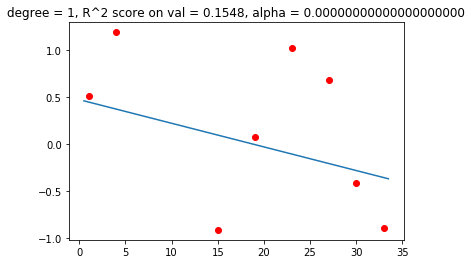

In [10]:
train_and_draw(nois_train_x, nois_train_y, nois_val_x, nois_val_y, Regression, deg=1)

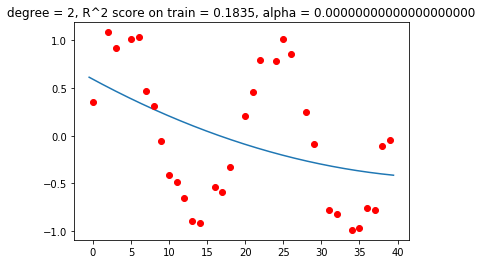

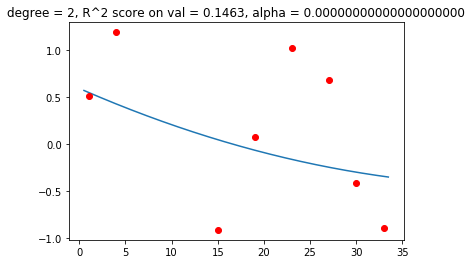

In [11]:
train_and_draw(nois_train_x, nois_train_y, nois_val_x, nois_val_y, Regression, deg=2)

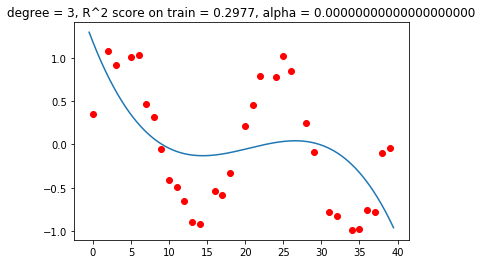

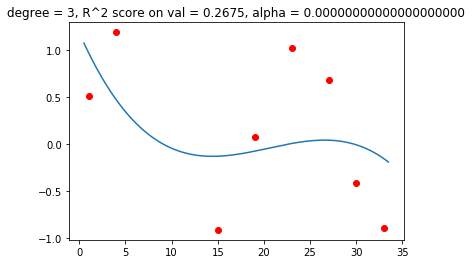

In [12]:
train_and_draw(nois_train_x, nois_train_y, nois_val_x, nois_val_y, Regression, deg=3)

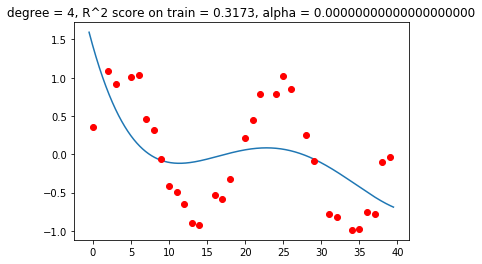

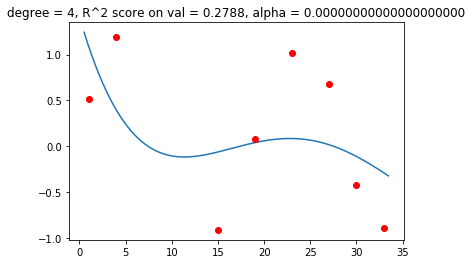

In [13]:
train_and_draw(nois_train_x, nois_train_y, nois_val_x, nois_val_y, Regression, deg=4)

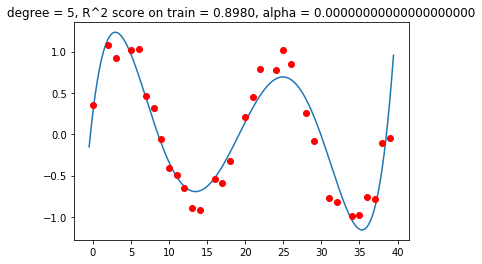

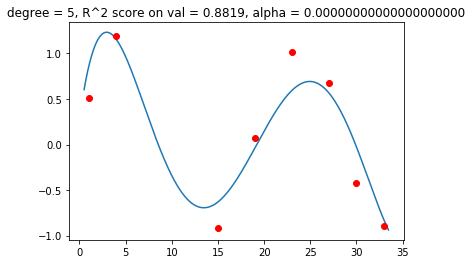

In [14]:
train_and_draw(nois_train_x, nois_train_y, nois_val_x, nois_val_y, Regression, deg=5)

In [15]:
for deg in [1, 2]:
    _, (train_r2, val_r2) = train(hydr_train_x, hydr_train_y, hydr_val_x, hydr_val_y, Regression, deg=deg)
    print("degree = {}, R^2 score on {} = {:.4f}".format(deg, "train", train_r2))
    print("degree = {}, R^2 score on {} = {:.4f}".format(deg, "val", val_r2))

degree = 1, R^2 score on train = 0.6636
degree = 1, R^2 score on val = 0.6210
degree = 2, R^2 score on train = 0.9346
degree = 2, R^2 score on val = 0.8947


In [16]:
def find_best_a(train_xs, train_ys, val_xs, val_ys, Regression, aa, deg=1):
    best_a = None
    best_r2 = -(10 ** 8)
    for a in aa:
        _, (_, r2) = train(train_xs, train_ys, val_xs, val_ys, Regression, deg=deg, a=a)
        if best_r2 < r2:
            best_r2, best_a = r2, a
            
    return train(train_xs, train_ys, val_xs, val_ys, Regression, deg=deg, a=best_a), best_a

def find_best_a_and_draw(train_xs, train_ys, val_xs, val_ys, Regression, aa, deg=1, print_used_features=False):
    (reg, _), a = find_best_a(train_xs, train_ys, val_xs, val_ys, Regression, aa=aa, deg=deg)
    
    if print_used_features:
        used_features = sum([0 if np.isclose(coef, 0) else 1 for coef in reg.coef_])
    else:
        used_features = None
    
    draw(train_xs, train_ys, reg.predict, deg, name="train", a=a, used_features=used_features)
    draw(val_xs, val_ys, reg.predict, deg, name="val", a=a, used_features=used_features)

In [17]:
aa = [x for d in range(-19, 1) for x in np.arange(10 ** d, 10 ** (d + 1), 9 * 10 ** d / 100)]

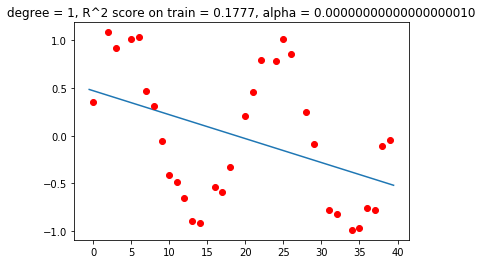

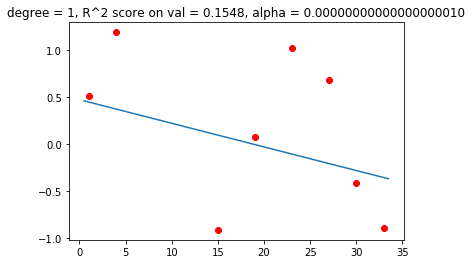

In [18]:
find_best_a_and_draw(nois_train_x, nois_train_y, nois_val_x, nois_val_y, Regression, aa=aa, deg=1)

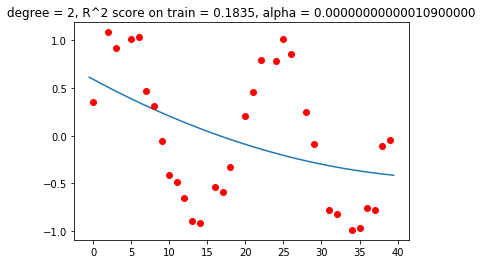

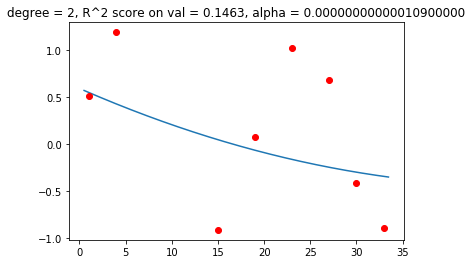

In [19]:
find_best_a_and_draw(nois_train_x, nois_train_y, nois_val_x, nois_val_y, Regression, aa=aa, deg=2)

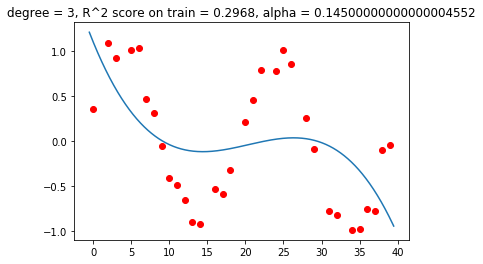

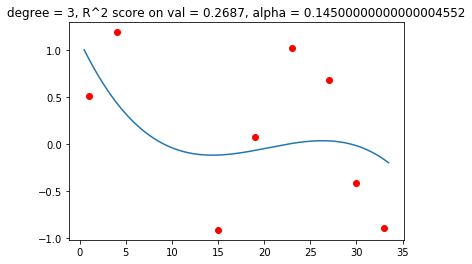

In [20]:
find_best_a_and_draw(nois_train_x, nois_train_y, nois_val_x, nois_val_y, Regression, aa=aa, deg=3)

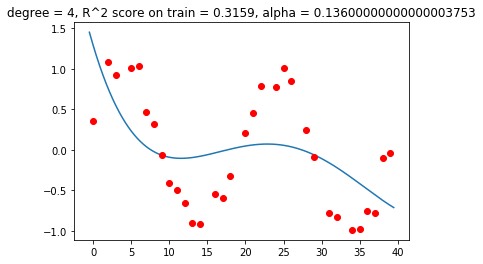

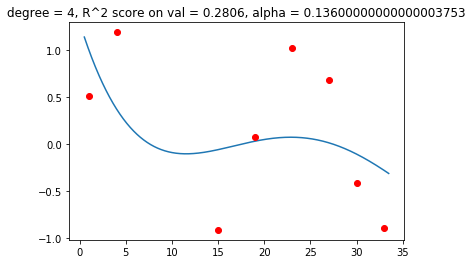

In [21]:
find_best_a_and_draw(nois_train_x, nois_train_y, nois_val_x, nois_val_y, Regression, aa=aa, deg=4)

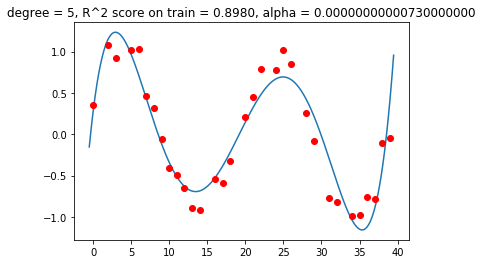

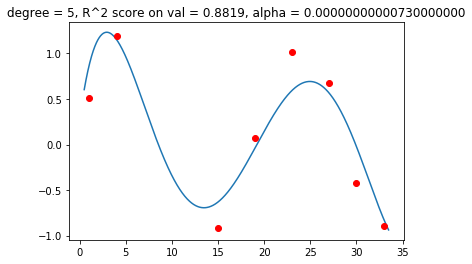

In [22]:
find_best_a_and_draw(nois_train_x, nois_train_y, nois_val_x, nois_val_y, Regression, aa=aa, deg=5)

In [23]:
for deg in [1, 2]:
    (_, (train_r2, val_r2)), a = find_best_a(hydr_train_x, hydr_train_y, hydr_val_x, hydr_val_y, 
                                             Regression, aa=aa, deg=deg)
    print("degree = {}, R^2 score on {} = {:.4f}, alpha = {:.20f}".format(deg, "train", train_r2, a))
    print("degree = {}, R^2 score on {} = {:.4f}, alpha = {:.20f}".format(deg, "val", val_r2, a))

degree = 1, R^2 score on train = 0.6636, alpha = 0.00000000000415000000
degree = 1, R^2 score on val = 0.6210, alpha = 0.00000000000415000000
degree = 2, R^2 score on train = 0.9342, alpha = 0.00019900000000000001
degree = 2, R^2 score on val = 0.8973, alpha = 0.00019900000000000001


In [24]:
class RegressionLasso(linear_model.Lasso):
    def __init__(self, alpha=0):
        super().__init__(alpha=alpha, max_iter=10 ** 4)

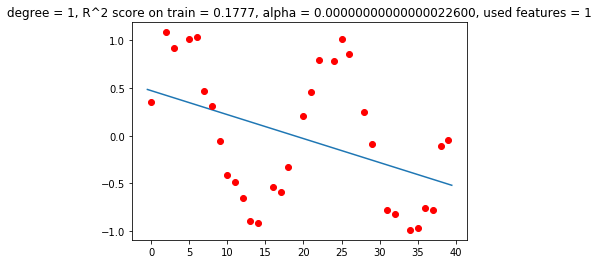

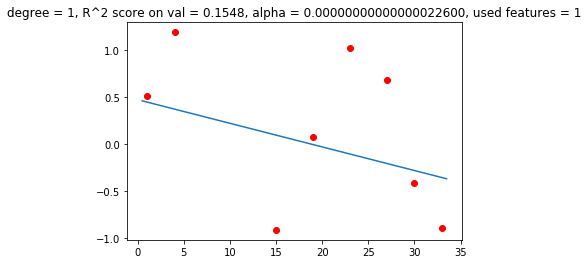

In [25]:
find_best_a_and_draw(nois_train_x, nois_train_y, nois_val_x, nois_val_y, 
                     RegressionLasso, aa=aa, deg=1, print_used_features=True)

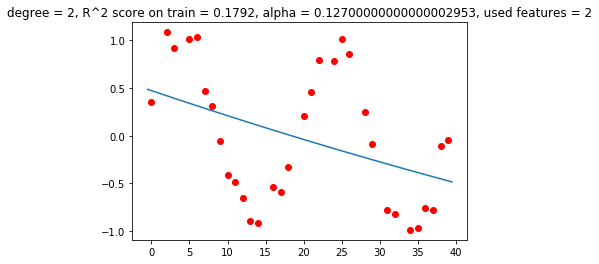

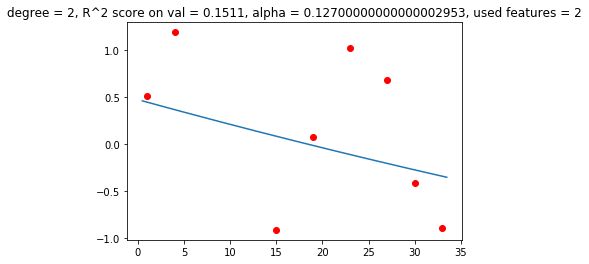

In [26]:
find_best_a_and_draw(nois_train_x, nois_train_y, nois_val_x, nois_val_y,
                     RegressionLasso, aa=aa, deg=2, print_used_features=True)

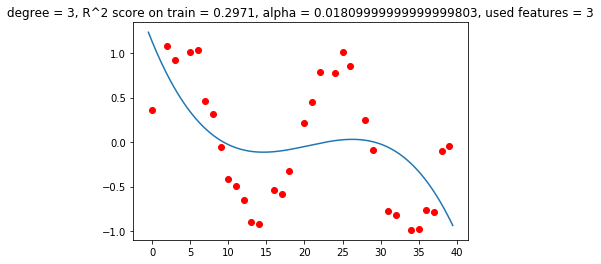

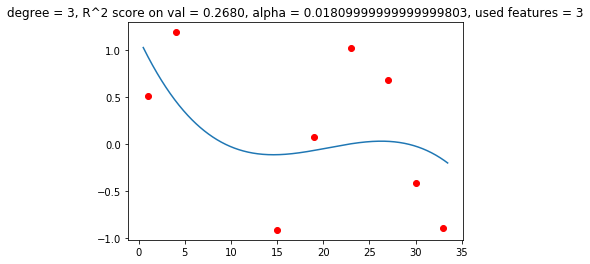

In [27]:
find_best_a_and_draw(nois_train_x, nois_train_y, nois_val_x, nois_val_y,
                     RegressionLasso, aa=aa, deg=3, print_used_features=True)

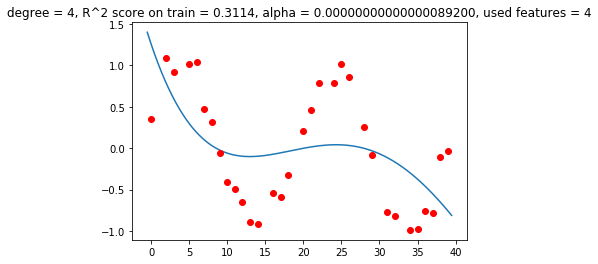

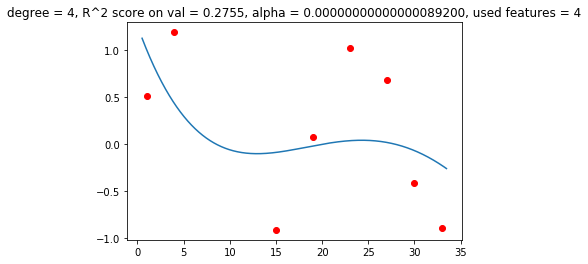

In [28]:
find_best_a_and_draw(nois_train_x, nois_train_y, nois_val_x, nois_val_y,
                     RegressionLasso, aa=aa, deg=4, print_used_features=True)

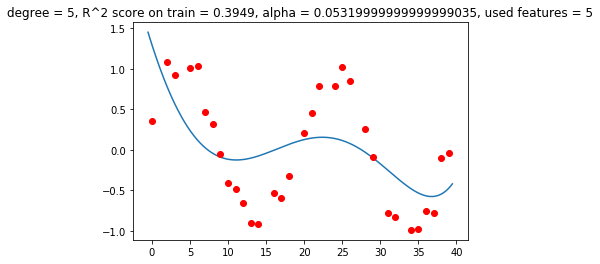

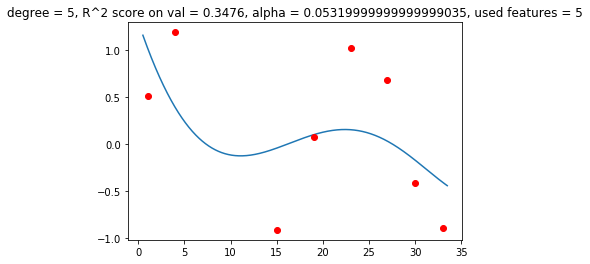

In [29]:
find_best_a_and_draw(nois_train_x, nois_train_y, nois_val_x, nois_val_y,
                     RegressionLasso, aa=aa, deg=5, print_used_features=True)

In [30]:
for deg in [1, 2]:
    (reg, (train_r2, val_r2)), a = find_best_a(hydr_train_x, hydr_train_y, hydr_val_x, hydr_val_y, 
                                               RegressionLasso, aa=aa, deg=deg)
    
    used_features = sum([0 if np.isclose(coef, 0) else 1 for coef in reg.coef_])
    
    print("degree = {}, R^2 score on {} = {:.4f}, alpha = {:.20f}".format(deg, "train", train_r2, a))
    print("degree = {}, R^2 score on {} = {:.4f}, alpha = {:.20f}".format(deg, "val", val_r2, a))
    print("used features = {}".format(used_features))
    print()

degree = 1, R^2 score on train = 0.6635, alpha = 0.00181000000000000019
degree = 1, R^2 score on val = 0.6214, alpha = 0.00181000000000000019
used features = 6

degree = 2, R^2 score on train = 0.9341, alpha = 0.00004330000000000000
degree = 2, R^2 score on val = 0.8987, alpha = 0.00004330000000000000
used features = 26

